In [1]:
#CREAR UN INDEX PARA ALMACENAR LOS DATOS
from elasticsearch import Elasticsearch
from pprint import pprint

es = Elasticsearch()

if not(es.indices.exists(index="tp5-championstweet")):
    res = es.indices.create(index="tp5-championstweet")  
    pprint(res)

1) En un histograma o en un line plot, visualizar el número de tweets conteniendo la palabra “goal”, cada minuto y cada 10 minutos. (BONUS: gestionar las variantes “goaaal”, “goooaallll”, etc. utilizando expresiones regulares).


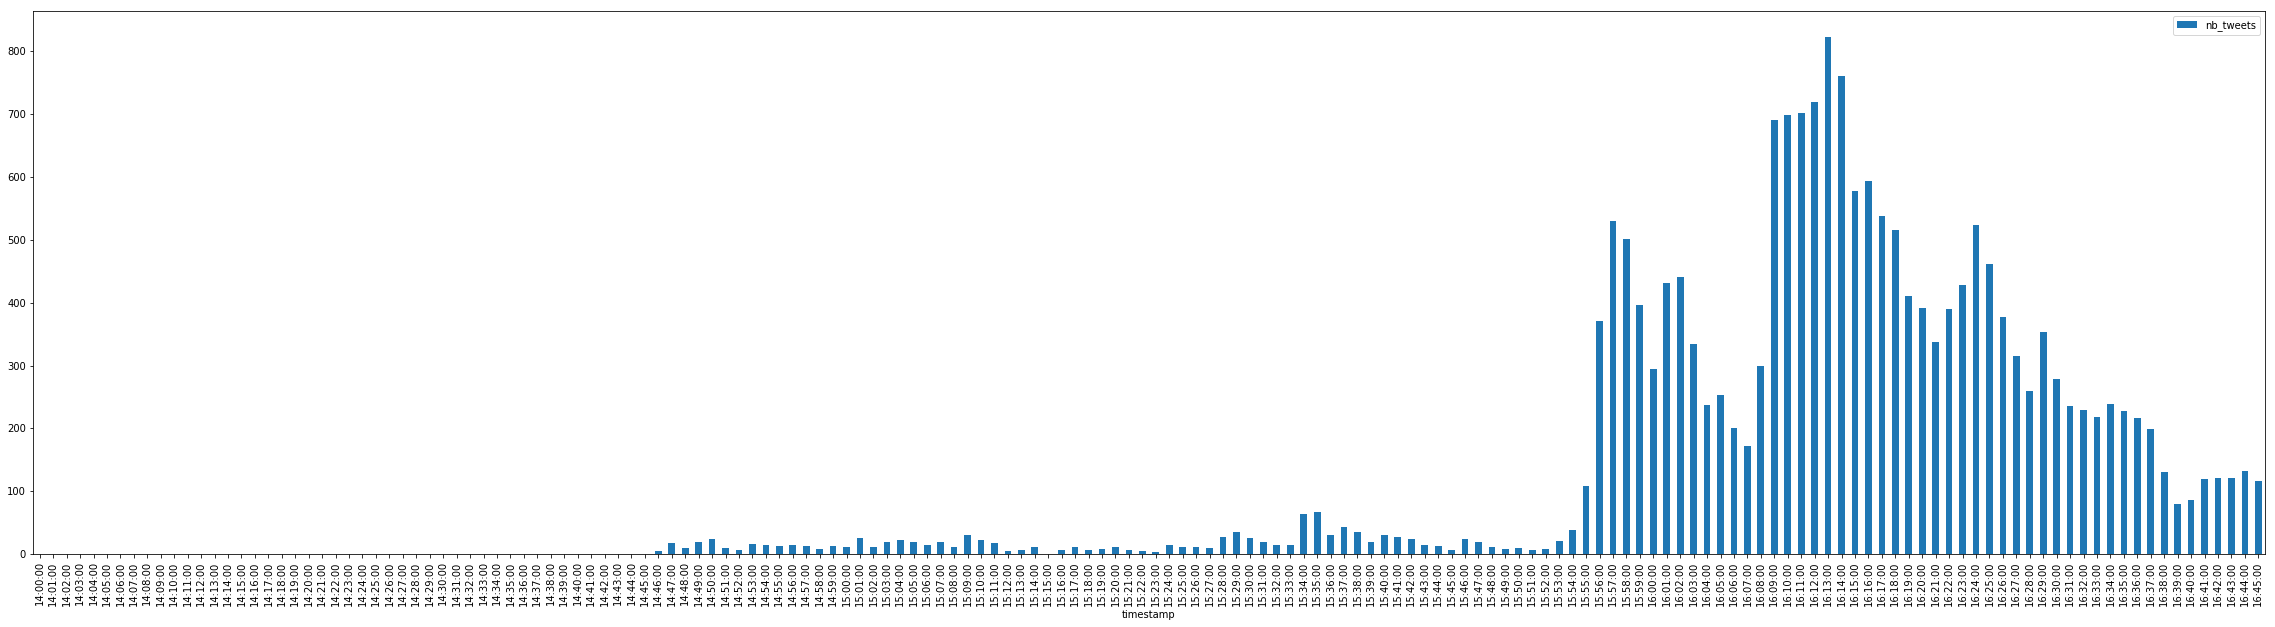

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
import datetime
%matplotlib inline

def timestamp2date(x):
    y = datetime.datetime.fromtimestamp(x/1000).strftime('%H:%M:%S')
    return y

res = es.search(index = 'tp5-championstweet', 
                body={"query":{"regexp":{"text":{"value":"g+o+a+l+"}}} ,
                      "size": 0,
                      "aggs" : { "tweets_over_time" : \
                                 { "date_histogram" : { "field" : \
                                                       "timestamp", "interval" : "1m"\
                                                      }}}})

df = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df = df.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets'})
df_filtrado = df.drop(df[df.timestamp < 1527357600000 ].index)
df_filtrado['timestamp']=df_filtrado['timestamp'].apply(timestamp2date)

df_filtrado.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

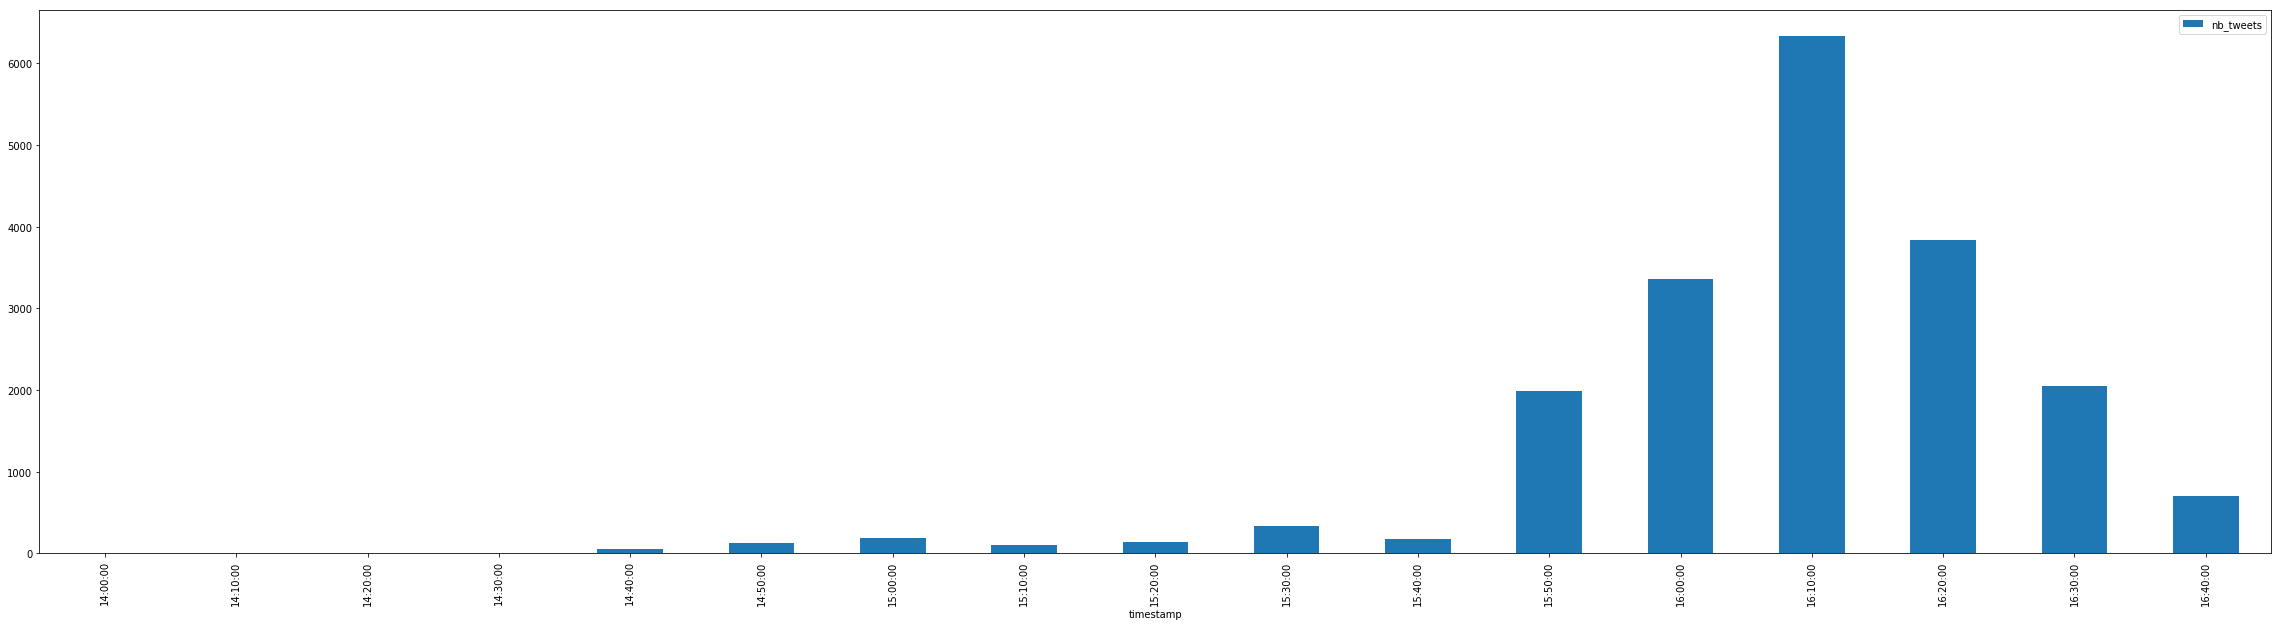

In [4]:
res2 = es.search(index = 'tp5-championstweet', 
                body={"query":{"regexp":{"text":{"value":"g+o+a+l+"}}} ,
                      "size": 0,
                      "aggs" : { "tweets_over_time" : \
                                 { "date_histogram" : { "field" : \
                                                       "timestamp", "interval" : "10m"\
                                                      }}}})

df2 = pd.DataFrame(res2['aggregations']['tweets_over_time']['buckets'])
df2 = df2.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets'})
df2_filtrado = df2.drop(df2[df2.timestamp < 1527357600000 ].index)
df2_filtrado['timestamp']=df2_filtrado['timestamp'].apply(timestamp2date)

df2_filtrado.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

2) En un histograma o en un  *line plot* ,  visualizar dos series de datos: 
 - el número de tweets que hablan de ‘liverpool’ por cada minuto,
 - el número de tweets que hablan de ‘madrid’ por cada minuto.

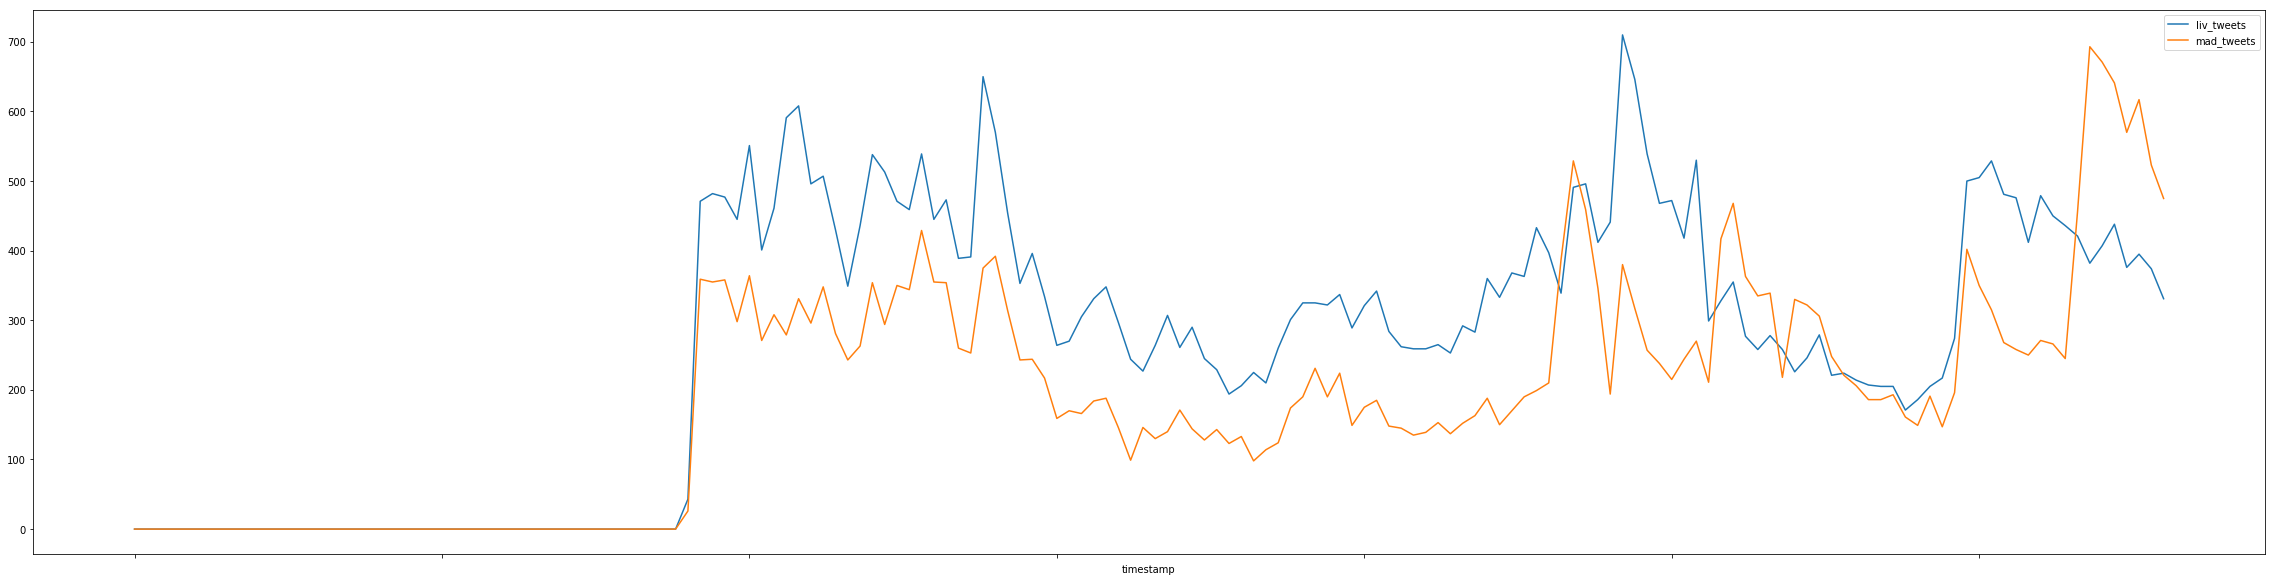

In [6]:
res_liv = es.search(index = 'tp5-championstweet', 
                body={"query": {"term":{"text":"liverpool"}},
                      "size": 0,
                      "aggs" : { "tweets_over_time" : \
                                 { "date_histogram" : { "field" : \
                                                       "timestamp", "interval" : "1m"\
                                                      }}}})
res_mad = es.search(index = 'tp5-championstweet', 
                body={"query": {"term":{"text":"madrid"}},
                      "size": 0,
                      "aggs" : { "tweets_over_time" : \
                                 { "date_histogram" : { "field" : \
                                                       "timestamp", "interval" : "1m"\
                                                      }}}})

df_liv = pd.DataFrame(res_liv['aggregations']['tweets_over_time']['buckets'])
df_liv = df_liv.rename(columns={'key': 'timestamp', 'doc_count': 'liv_tweets'})
df_liv_filtrado = df_liv.drop(df_liv[df_liv.timestamp < 1527357600000 ].index)
df_liv_filtrado['timestamp']=df_liv_filtrado['timestamp'].apply(timestamp2date)

df_mad = pd.DataFrame(res_mad['aggregations']['tweets_over_time']['buckets'])
df_mad = df_mad.rename(columns={'key': 'timestamp', 'doc_count': 'mad_tweets'})
df_mad_filtrado = df_mad.drop(df_mad[df_mad.timestamp < 1527357600000 ].index)
df_mad_filtrado['timestamp']=df_mad_filtrado['timestamp'].apply(timestamp2date)

df_eqp = pd.concat([df_liv_filtrado,df_mad_filtrado], axis=1)

df_eqp.plot(kind='line',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

¿A qué minuto se habla más de Madrid?

In [21]:
A = df_mad_filtrado['mad_tweets'].idxmax()
B = df_mad_filtrado['mad_tweets'].max()

#print(df_mad_filtrado.loc[df_mad_filtrado['mad_tweets'] == B])

print(df_mad_filtrado['timestamp'][A])

16:39:00


3) En un dataframe, mostrar el número de tweets según el país indicado en el campo
‘location’. ¿Desde cuáles países se enviaron los tweets? (BONUS: mostrar los
resultados en una mapa).

In [109]:
res_location = es.search(index="tp5-championstweet", body={"query": {"match_all": {}},
                                                           "size":0,
                                                           "aggs":{
                                                               "by_location":{
                                                                   "terms" :{
                                                                       "field":"location.keyword",
                                                                       "size":250000
                                                                       }}}})

df_location = pd.DataFrame(res_location['aggregations']['by_location']['buckets'])
df_location = df_location.rename(columns={'key': 'location', 'doc_count': 'tweets_from_location'})


print(df_location)


       tweets_from_location                     location
0                      3530               Lagos, Nigeria
1                      2580                      Nigeria
2                      1926              London, England
3                      1753               Nairobi, Kenya
4                      1633                 South Africa
5                      1396   Johannesburg, South Africa
6                      1204                       London
7                      1016                       Brasil
8                      1010               United Kingdom
9                       943       Rio de Janeiro, Brasil
10                      909                    Indonesia
11                      899               Abuja, Nigeria
12                      831                 Cairo, Egypt
13                      820                United States
14                      819                     Malaysia
15                      805      England, United Kingdom
16                      787    

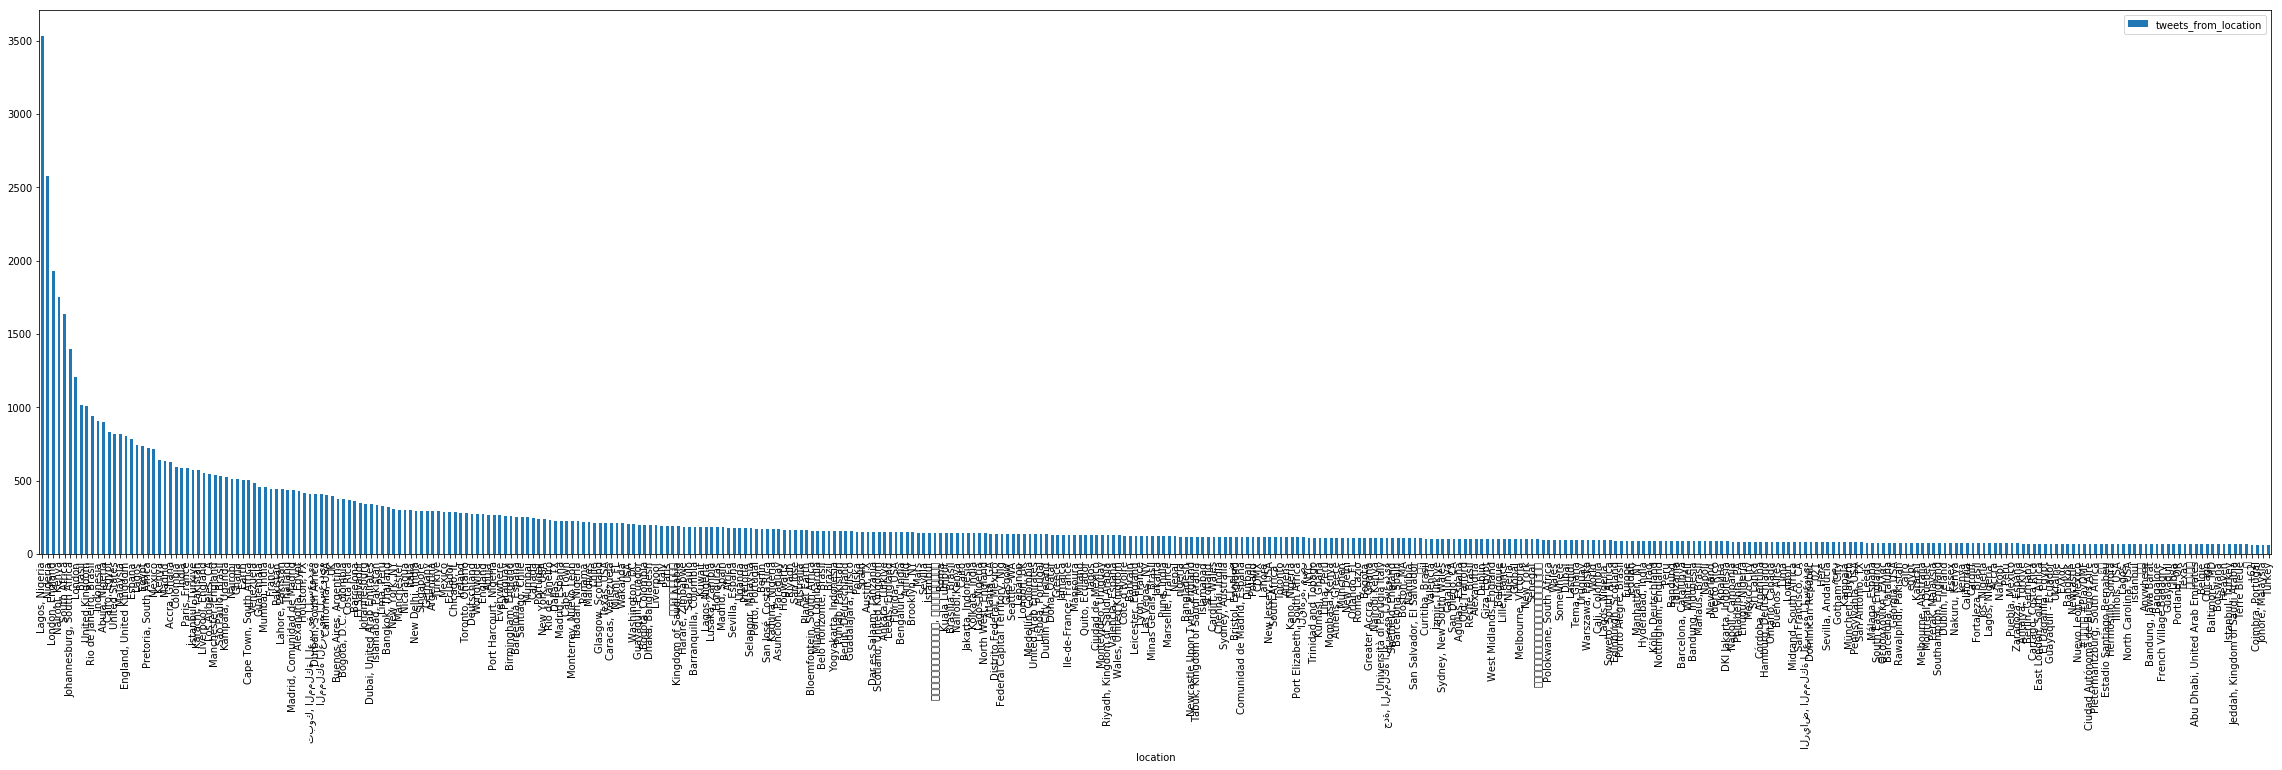

In [107]:
# no se pueden graficar todos ya que el signo '$' en algun texto produce un error
df_location[:400].plot(kind='bar',figsize=(40,10), fontsize=10, x='location')
plt.show()

4) En un histograma o en un  *line plot*, visualizar dos series de datos:
- el número de tweets enviado desde Inglaterra, por cada minuto.
- el número de tweets enviado desde España, por cada minuto.

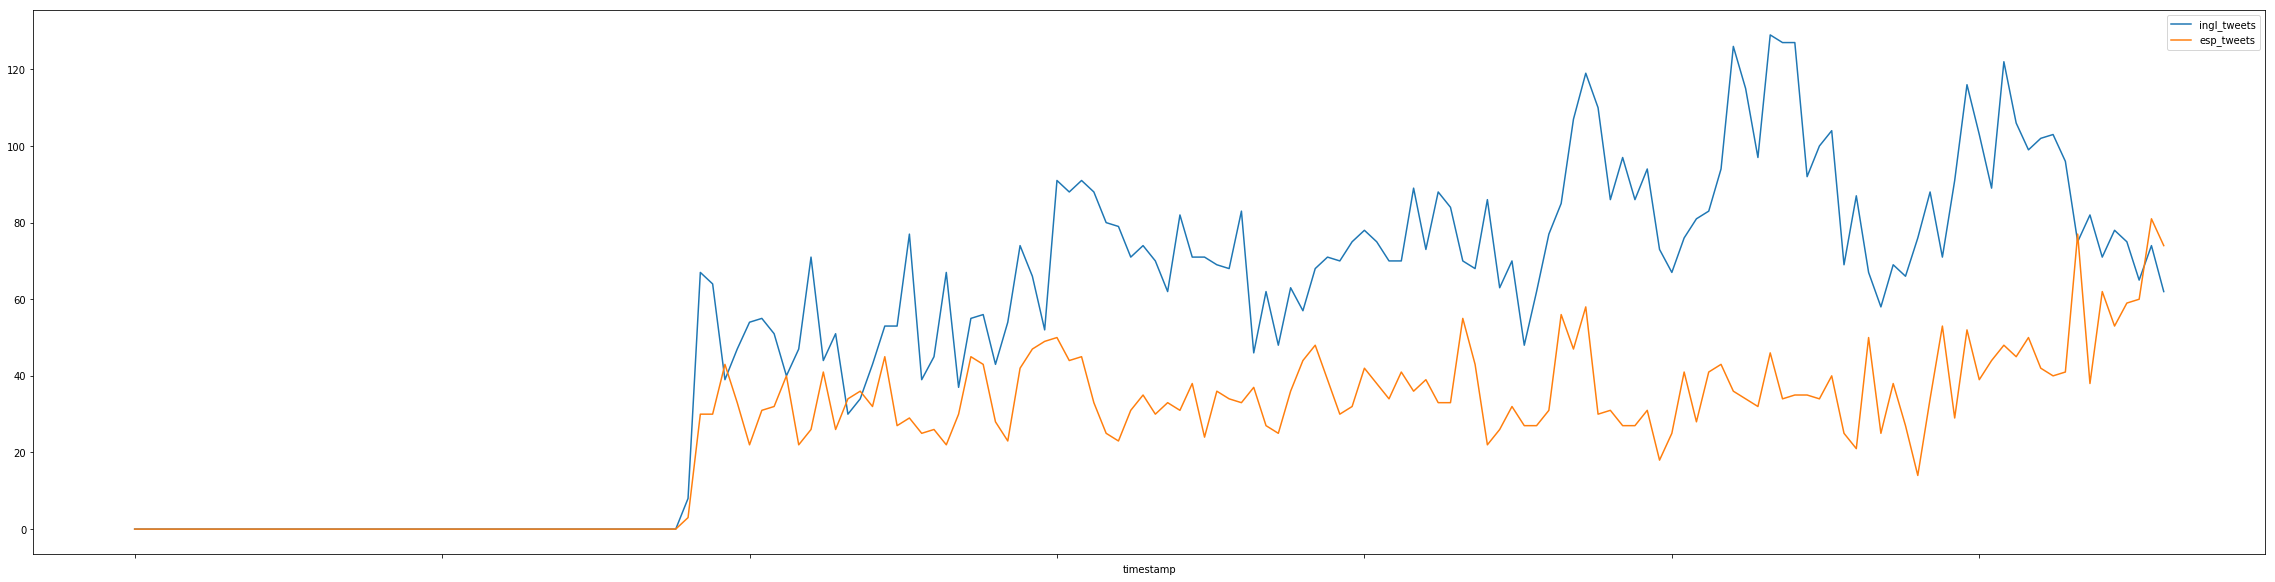

In [4]:
res_ingl = es.search(index = 'tp5-championstweet', 
                body={"query": {"term":{"location":"england"}},
                      "size": 0,
                      "aggs" : { "tweets_over_time" : \
                                 { "date_histogram" : { "field" : \
                                                       "timestamp", "interval" : "1m"\
                                                      }}}})
res_esp = es.search(index = 'tp5-championstweet', 
                body={"query": {"term":{"location":"españa"}},
                      "size": 0,
                      "aggs" : { "tweets_over_time" : \
                                 { "date_histogram" : { "field" : \
                                                       "timestamp", "interval" : "1m"\
                                                      }}}})

df_ingl = pd.DataFrame(res_ingl['aggregations']['tweets_over_time']['buckets'])
df_ingl = df_ingl.rename(columns={'key': 'timestamp', 'doc_count': 'ingl_tweets'})
df_ingl_filtrado = df_ingl.drop(df_ingl[df_ingl.timestamp < 1527357600000 ].index)
df_ingl_filtrado['timestamp']=df_ingl_filtrado['timestamp'].apply(timestamp2date)

df_esp = pd.DataFrame(res_esp['aggregations']['tweets_over_time']['buckets'])
df_esp = df_esp.rename(columns={'key': 'timestamp', 'doc_count': 'esp_tweets'})
df_esp_filtrado = df_esp.drop(df_esp[df_esp.timestamp < 1527357600000 ].index)
df_esp_filtrado['timestamp']=df_esp_filtrado['timestamp'].apply(timestamp2date)

df_ingl_filtrado= df_ingl_filtrado.reset_index(drop=True)
df_esp_filtrado = df_esp_filtrado.reset_index(drop=True)

df_nac = pd.concat([df_ingl_filtrado, df_esp_filtrado], axis=1)

df_nac.plot(kind='line',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()


5) ¿Cómo podríamos analizar las emociones expresadas durante el partido? Proponer
una metodología para responder a esta pregunta. (No es obligatorio implementar su
metodología pero debe ser factible con las tecnologías que conocen).

Creando 2 json, uno con palabras positivas y asignándole valores positivos dependiendo de lo fuerte de la emoción y otro con palabras negativas con valores negativos. Crear un programa que analiza cada tweet y si las palabras usadas en el tweet están en alguno de los json entonces se suman los valores y se  retorna un valor para ese tweet. Iterando sobre los tweets ordenados por minuto y pasando la información generada desde el programa a un dataframe, se puede generar un gráfico que muestra lo positivo o negativo de las emocines de la gente durante el partido.